In [1]:
from __future__ import print_function
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.callbacks import TensorBoard
from tqdm import tqdm
import numpy as np
from bert4keras.backend import keras, K
from bert4keras.layers import Loss
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab, SpTokenizer
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, is_string
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder
from keras.models import Model
import random
import cv2

Using TensorFlow backend.


In [2]:
# 模型配置
maxlen = 128
batch_size = 15
epochs = 100

# VGG or ResNet
CNN_model = "VGG"

# 是否重新訓練，或是載入訓練好的模型
train_model = False

In [3]:
# 讀取 BERT設定以及詞表
config_path = './uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = './uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = './uncased_L-12_H-768_A-12/vocab.txt'

In [4]:
# 讀取以及簡化詞表
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

In [5]:
#讀取 IU_XAY 的文字描述，刪除不必要的空白，以及將文字轉換成小寫

def read_train_caption(data):

    images = {}
    
    for i in tqdm(range(len(data))):

        if pd.isnull(data["findings"][i]) == False:
            images[data["filename"][i]] = {
                'image_id': data["filename"][i],
                'caption': (str(data["impression"][i])+str(data["findings"][i])).replace('   ', ' ').replace('  ', ' ').replace('. .', '.').replace('..', '.').lower(),
                'path': "./images/images_normalized/"+str(data["filename"][i])
            }

        elif pd.isnull(data["impression"][i]) == False:
            images[data["filename"][i]] = {
                'image_id': data["filename"][i],
                'caption': str(data["impression"][i]).replace('   ', ' ').replace('  ', ' ').replace('. .', '.').replace('..', '.').lower(),
                'path': "./images/images_normalized/"+str(data["filename"][i])
            }
        else:
            pass

    return list(images.values())


In [6]:
#讀取影像並將非正方圖形，使用黑色將其補為正方形

def read_image(f):

    img = cv2.imread(f)
    height, width = img.shape[:2]
    if height > width:
        height, width = img_size, width * img_size // height
        img = cv2.resize(img, (width, height))
        delta = (height - width) // 2
        img = cv2.copyMakeBorder(
            img,
            top=0,
            bottom=0,
            left=delta,
            right=height - width - delta,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )
    else:
        height, width = height * img_size // width, img_size
        img = cv2.resize(img, (width, height))
        delta = (width - height) // 2
        img = cv2.copyMakeBorder(
            img,
            top=delta,
            bottom=width - height - delta,
            left=0,
            right=0,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )
    img = img.astype('float32')
    return img[..., ::-1]  # BGR轉 RGB

In [7]:
class data_generator(DataGenerator):
#將影像以及資料整理成可供模型訓練的格式
    def __iter__(self, random=False):
        batch_images, batch_token_ids, batch_segment_ids = [], [], []
        for is_end, D in self.sample(random):
            img = D['path']
            caption = D['caption']
            token_ids, segment_ids = tokenizer.encode(caption, max_length=maxlen)
            batch_images.append(read_image(img))
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_images = np.array(batch_images)
                batch_images = preprocess_input(batch_images)
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                yield [batch_token_ids, batch_segment_ids, batch_images], None
                batch_images, batch_token_ids, batch_segment_ids = [], [], []

In [8]:
#讀取整理好的 CSV檔案，其中使用 findgind & impression欄位共大於15字才列入訓練資料

train_ = pd.read_csv("./count15_train.csv")
test_  = pd.read_csv("./count15_test.csv")

In [9]:
train_data = read_train_caption(train_)
test_data  = read_train_caption(test_ )
len(train_data),len(test_data)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12227.44it/s]


(6490, 500)

In [10]:
class CrossEntropy(Loss):
    """mask掉padding部分
    """
    def compute_loss(self, inputs, mask=None):
        y_true, y_pred = inputs
        if mask[1] is None:
            y_mask = 1.0
        else:
            y_mask = K.cast(mask[1], K.floatx())[:, 1:]
        y_true = y_true[:, 1:]  # 目標token_ids
        y_pred = y_pred[:, :-1]  # 預測序列，錯開一列
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss



In [11]:
#使用 pre-trained CNN model 作為影像特徵的擷取

if CNN_model == "VGG":
    VGG19      = keras.applications.vgg19.VGG19
    preprocess_input = keras.applications.vgg19.preprocess_input
    image_model = VGG19(include_top=False, pooling='avg')
else:
    ResNet152V2      = keras.applications.resnet_v2.ResNet152V2
    preprocess_input = keras.applications.resnet_v2.ResNet152V2
    image_model = ResNet152V2(include_top=False, pooling='avg')
    
    
img_size = 224

In [12]:
# Bert模型
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='lm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精簡字表
    layer_norm_cond=image_model.output,
    layer_norm_cond_hidden_size=128,
    layer_norm_cond_hidden_act='swish',
    additional_input_layers=image_model.input,
)

output = CrossEntropy(1)([model.inputs[0], model.outputs[0]])
model = Model(model.inputs, output)
model.compile(optimizer=Adam(1e-5))

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\keras\engine\training_utils.py:819: UserWarning: Output cross_entropy_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cross_entropy_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [13]:
#使用 Transformer作為 Decoder，使用 beam search top_k = 3

class AutoCaption(AutoRegressiveDecoder):

    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        image = inputs[0]
        token_ids = output_ids
        segment_ids = np.zeros_like(token_ids)
        return model.predict([token_ids, segment_ids, image])[:, -1]

    def generate(self, image, topk=3):
        if is_string(image):
            image = read_image(image)
        image = preprocess_input(image)
        output_ids = self.beam_search([image], topk)  # beam search top_k = 3
        return tokenizer.decode(output_ids)


autocaption = AutoCaption(
    start_id=tokenizer._token_start_id,
    end_id=tokenizer._token_end_id,
    maxlen=maxlen
)

In [14]:
from PIL import Image
from rouge import Rouge  # pip install rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

##just show 用於訓練時即時顯示初步的訓練結果以及影像

def just_show():
    samples = [test_data[i] for i in np.random.choice(len(test_data), 10)]
    bleu_1,total = 0, 0
    for D in samples:
        total += 1
        img = D['path']
        temp_image = np.array(Image.open(img))
        fig = plt.figure(figsize=(10, 10))
        #ax  =fig.set_title(D['image_id'])
        capa = autocaption.generate(img)
        pred_title = ' '.join(capa)
        title = ' '.join(D["caption"])
        print(u'image_id:', D['image_id'])
        print(u'predict:')
        print(capa)
        print()
        print(u'references:')
        print(D['caption'])
        print()
        if pred_title.strip():
            #scores = Rouge().get_scores(hyps=pred_title, refs=title)
            #rouge_1 += scores[0]['rouge-1']['f']
            #rouge_2 += scores[0]['rouge-2']['f']
            #rouge_L += scores[0]['rouge-l']['f']
            bleu_1  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(1.0, 0, 0, 0)
            )


        bleu_1  /= total
        print('bleu_1:', bleu_1)
        print()
        bleu_1,total = 0, 0
        plt.axis("off")
        plt.imshow(temp_image,cmap="gray")
        plt.tight_layout()
        plt.show()

In [15]:
class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        # 儲存權重
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save_weights('./count15_final.weights')
        # 即時顯示訓練結果
        just_show()
        



In [16]:
len(train_data),len(test_data)

(6490, 500)

In [17]:
steps_per_epoch = len(train_data)//batch_size
evaluator = Evaluate()
train_generator = data_generator(train_data, batch_size)
len(train_generator)

433

In [18]:
#重新訓練模型，或是載入訓練好的模型
if train_model == True:

    train_history = model.fit_generator(
                  train_generator.forfit(),
                  steps_per_epoch=steps_per_epoch,
                  epochs=epochs,
                  callbacks=[evaluator]
    )
    
elif CNN_model == "VGG":
    model.load_weights('./VGG19.weights')

else:
    model.load_weights('./ResNet.weights')

image_id: 2559_IM-1063-1001.dcm.png
predict:
no acute cardiopulmonary disease. the heart, pulmonary and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pneumonia. there are mild degenerative changes of the spine.

references:
no evidence of active disease.the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.

bleu_1: 0.7344827586206897



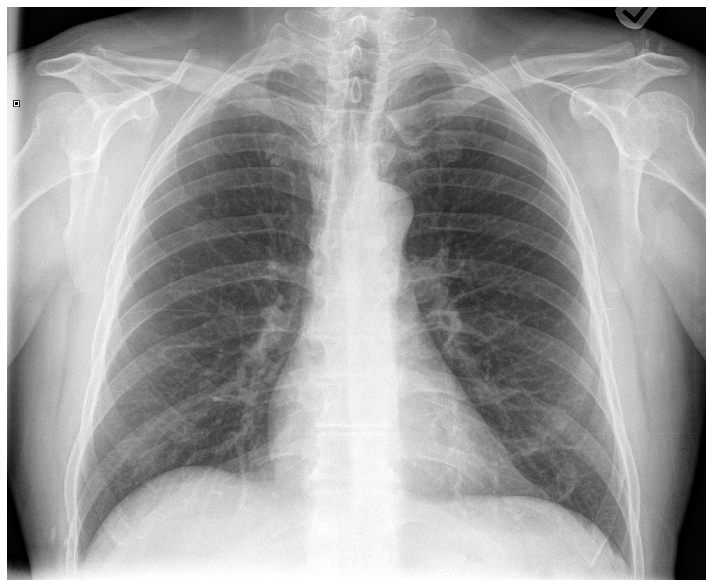

image_id: 3192_IM-1505-2001.dcm.png
predict:
no acute cardiopulmonary disease. lungs are clear. there is no focal consolidation, pleural effusion, or pneumothorax. the heart and mediastinum are normal size and shape. and soft tissues are unremarkable.

references:
 increased left hilar fullness. this may represent superimposed , adenopathy cannot be excluded on this exam. if there is clinical concern, suggest reference to prior exam or ct chest. large hiatal hernia, increased in size from prior exam.the heart is normal in size. mild fullness of the left hilum, small interval change from prior exam. lucencies throughout the chest representing emphysematous change. scattered bilateral calcified granulomas. no pneumothorax. large hiatal hernia, increased from prior exam.

bleu_1: 0.221708447817513



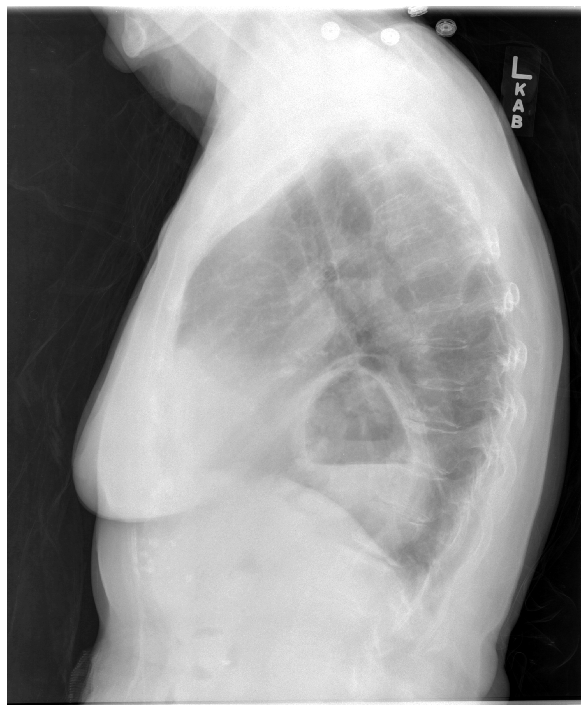

image_id: 1656_IM-0431-1001.dcm.png
predict:
no evidence of active disease. heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.

references:
clear lungs. no acute cardiopulmonary abnormality.the lungs are clear. heart size is normal. no pneumothorax.

bleu_1: 0.5581395348837209



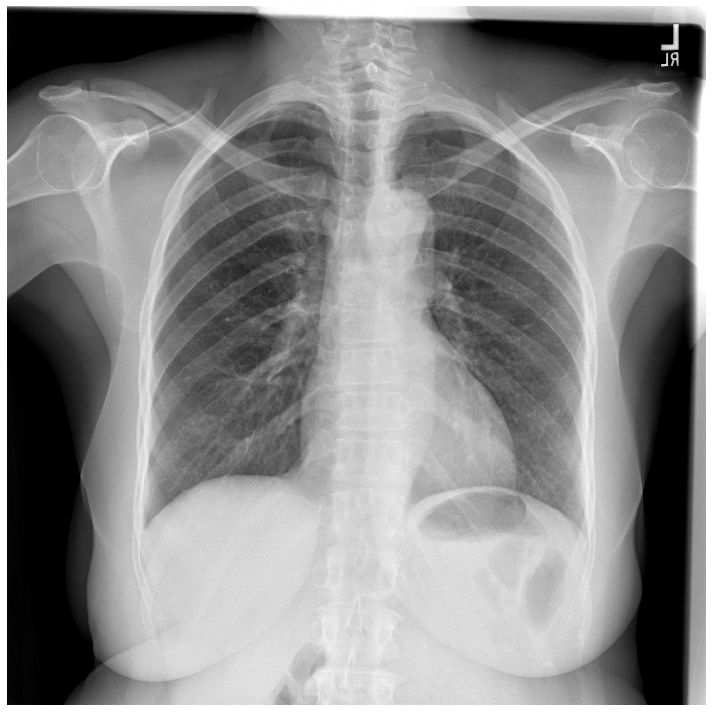

image_id: 3268_IM-1551-1001.dcm.png
predict:
no acute cardiopulmonary process. the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. no acute bone abnormality.

references:
no acute cardiopulmonary abnormalities.the heart is normal in size and contour. there is no mediastinal widening. the lungs are clear bilaterally. no large pleural effusion or pneumothorax. the are intact.

bleu_1: 0.8091872791519434



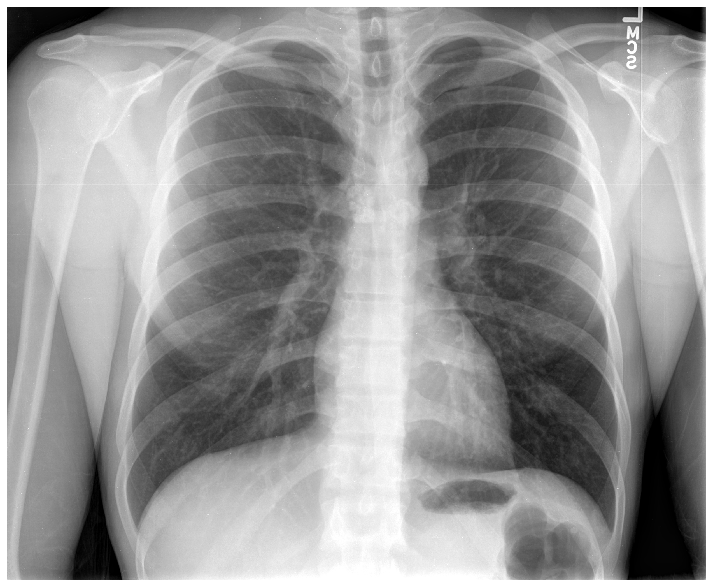

image_id: 2036_IM-0680-1001.dcm.png
predict:
cardiomegaly and small bilateral pleural effusions abnormal pulmonary opacities most suggestive of pulmonary edema, primary differential diagnosis includes infection and aspiration, clinical correlation recommendedmoderate-to-marked enlargement of the cardiac silhouette, mediastinal contours appear similar to prior. mild bilateral pleural effusions, left greater than left. no pneumothorax.

references:
 bibasilar airspace disease, greater on the right, either atelectasis or infiltrate. platelike right midlung atelectasis.there is mild cardiomegaly. the thoracic aorta is tortuous. lung volumes are low with asymmetric elevation of the right hemidiaphragm. there is platelike atelectasis in the right midlung along with bibasilar airspace disease, either atelectasis or infiltrate. no pneumothorax.

bleu_1: 0.8195862075313549



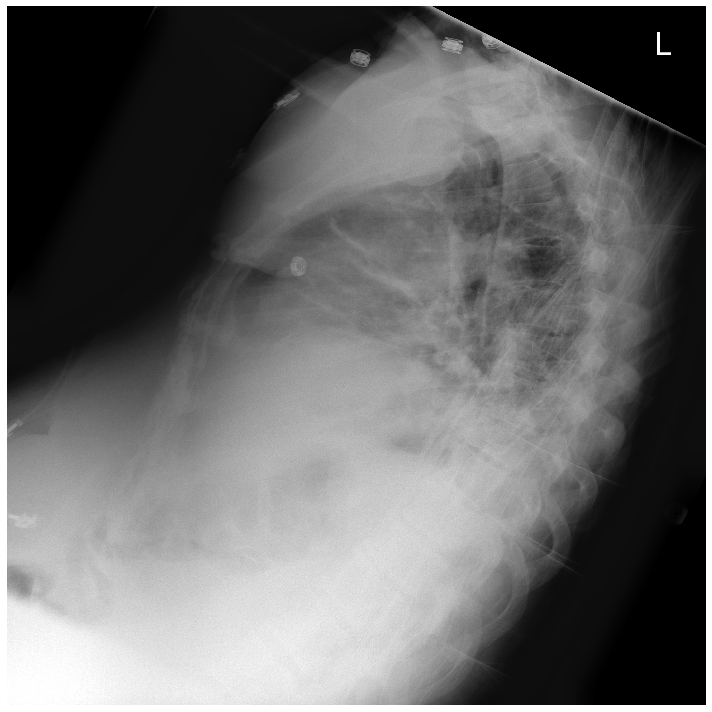

image_id: 1514_IM-0333-2001.dcm.png
predict:
no acute cardiopulmonary abnormalities. normal heart size and mediastinal contours. no focal airspace opacity. no pleural effusion or pneumothorax. visualized osseous structures are unremarkable in appearance.

references:
 no acute cardiopulmonary abnormality. left midlung subsegmental atelectasis versus scar.cardiomediastinal silhouette is within normal limits of size and appearance. the pulmonary vascularity is unremarkable. there are opacities in the left , subsegmental atelectasis or scar. otherwise, the lungs are expanded and clear of airspace disease. negative for pneumothorax or pleural effusion. limited bone evaluation reveals no acute abnormality.

bleu_1: 0.31948824473148035



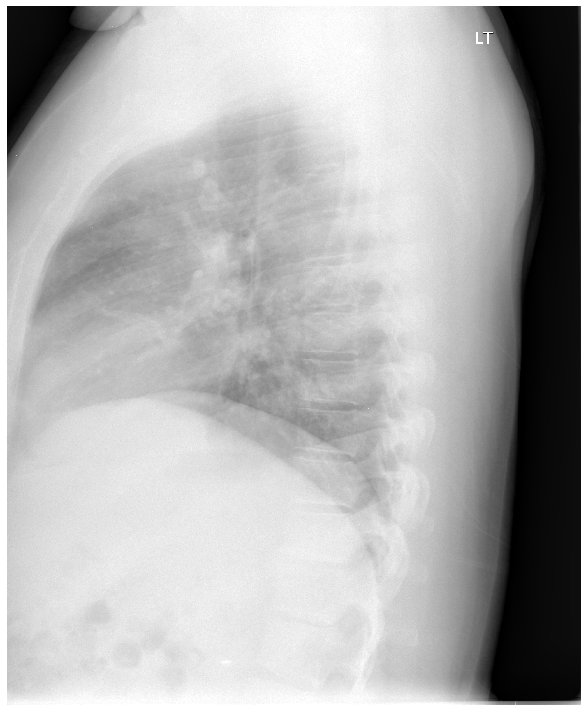

image_id: 2694_IM-1165-2001.dcm.png
predict:
no acute cardiopulmonary findingsheart size within normal limits, stable mediastinal and hilar contours. no alveolar consolidation, no findings of pleural effusion or pulmonary edema. no pneumothorax.

references:
no acute cardiopulmonary disease.the heart is normal in size and contour. the lungs are clear, without evidence of infiltrate. there is no pneumothorax or effusion.

bleu_1: 0.7822222222222223



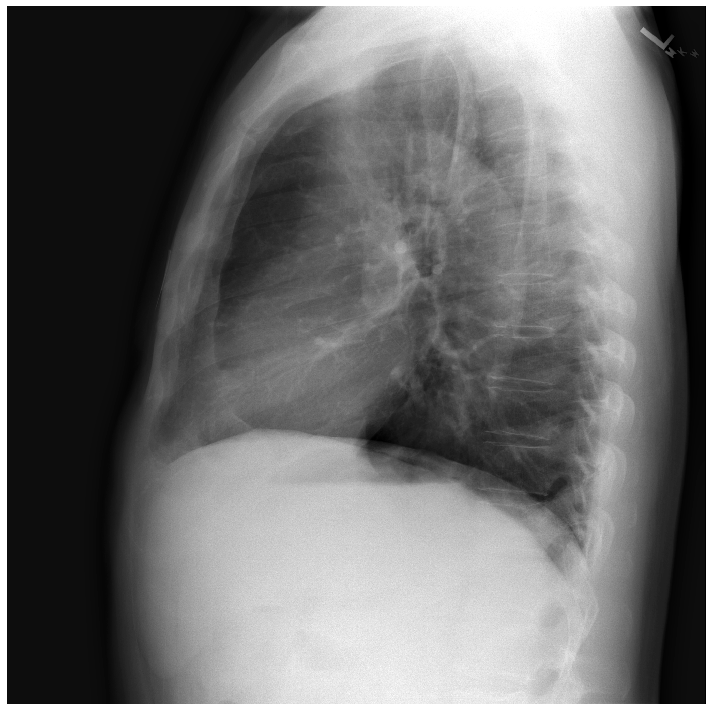

image_id: 2964_IM-1357-2001.dcm.png
predict:
no acute or active cardiac, pulmonary or pleural disease. frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette. normal mediastinal contour, pulmonary and vasculature, central airways and lung volumes. no pleural effusion.

references:
no evidence of active disease.the lungs are clear. there is no focal airspace consolidation. no pleural effusion or pneumothorax. heart size and mediastinal contour are normal.

bleu_1: 0.6503267973856209



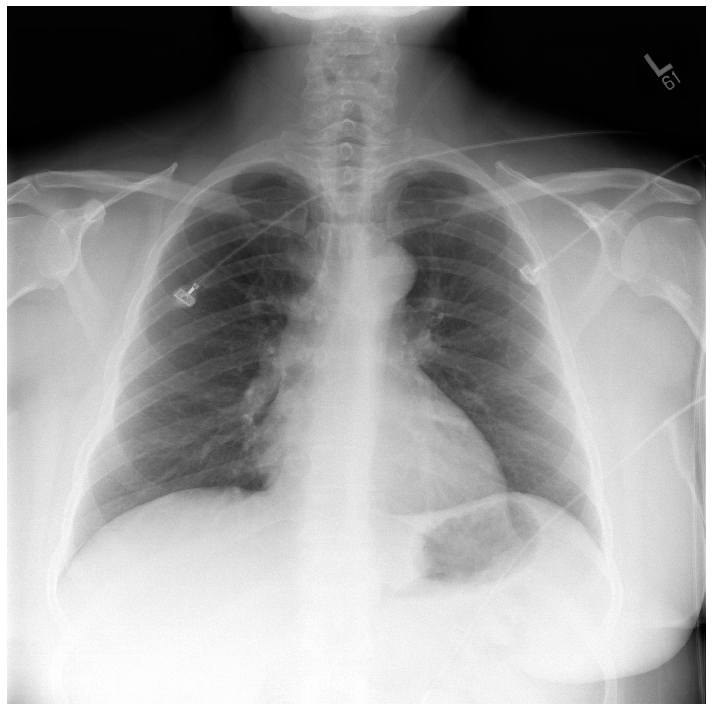

image_id: 1397_IM-0253-2001.dcm.png
predict:
no acute cardiopulmonary findings. the trachea is midline. the cardiomediastinal silhouette is normal. the lungs are clear, without evidence of focal consolidations or pleural effusion. there is no pneumothorax. the visualized bony structures reveal no acute abnormalities.

references:
heart size near top normal limits, stable mediastinal contours. no focal alveolar consolidation, no definite pleural effusion seen. no typical findings of pulmonary edema.

bleu_1: 0.6181229773462783



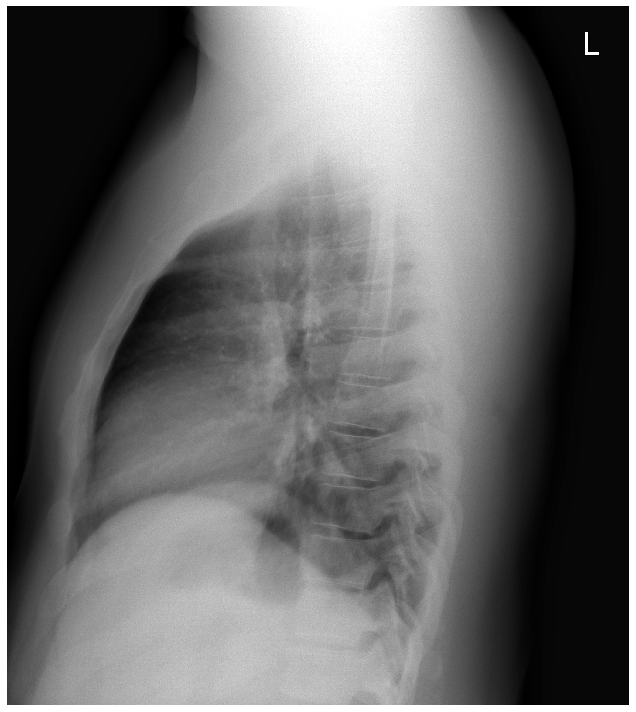

image_id: 2624_IM-1111-1001.dcm.png
predict:
no acute cardiopulmonary abnormality. the cardiomediastinal silhouette and pulmonary vasculature are within normal limits. there is no pneumothorax or pleural effusion. there are no focal areas of consolidation.

references:
 no acute cardiopulmonary process. age indetermit grade 1 anterior wedge deformity of lheart size and mediastinal contour are normal. pulmonary vascularity is normal. lungs are clear. no pleural effusions or pneumothoraces. there is a mild anterior wedge deformity of l1, age-indeterminate.

bleu_1: 0.6623318778386537



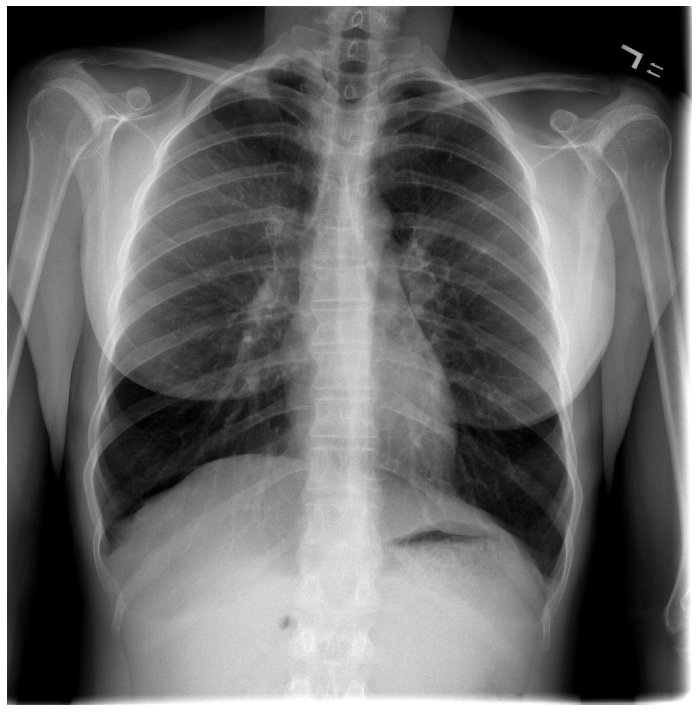

In [19]:
just_show()

In [20]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#將500筆測試資料使用訓練好的模型產生描述，以及平均 500筆資料所得到的各項標準分數

def Evaluate_test(test_data):
    total = 0
    rouge_1, rouge_2, rouge_L, bleu_1, bleu_2, bleu_3, bleu_4 = 0, 0, 0, 0, 0, 0, 0
    for D in tqdm(test_data):
        total += 1
        title = ' '.join(D["caption"])
        path  = D["path"]
        pred_title = ' '.join(autocaption.generate(path))
        if pred_title.strip():
            scores = Rouge().get_scores(hyps=pred_title, refs=title)
            rouge_1 += scores[0]['rouge-1']['f']
            rouge_2 += scores[0]['rouge-2']['f']
            rouge_L += scores[0]['rouge-l']['f']
            bleu_1  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(1.0, 0, 0, 0)
            )
            bleu_2  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.5, 0.5, 0, 0)
            )
            bleu_3  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.33, 0.33, 0.33, 0)
            )
            bleu_4  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.25, 0.25, 0.25, 0.25)
            )
    rouge_1 /= total
    rouge_2 /= total
    rouge_L /= total
    bleu_1  /= total
    bleu_2  /= total      
    bleu_3  /= total
    bleu_4  /= total
    return {
        'rouge-1': rouge_1,
        'rouge-2': rouge_2,
        'rouge-L': rouge_L,
        'bleu_1': bleu_1,
        'bleu_2': bleu_2,
        'bleu_3': bleu_3,
        'bleu_4': bleu_4,
    }

In [21]:
Evaluate_test(test_data)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [48:27<00:00,  5.81s/it]


{'rouge-1': 0.9224294936495717,
 'rouge-2': 0.6250400215426029,
 'rouge-L': 0.8715249880797927,
 'bleu_1': 0.6173024862047155,
 'bleu_2': 0.5454511397067838,
 'bleu_3': 0.48376701609267975,
 'bleu_4': 0.4289000705949729}